The purpose of this project is to model the career lengths of NFL running backs.  It has been said in the sports media that NFL running backs have short career lengths.  To see if that statement is true the career lifetimes of NFL running backs from 1970-2014 will be modeled using the survival analysis methods of Kaplan-Meier Estimation and Cox Regression.  Cox Regression will be used to predict career lengths using starting age, total number of plays, total TD's, total yards gained and the number of fumbles.  Additionally, we will try to develop an aging curve based on the Crow-AMSAA reliability growth model.

In [1]:
#importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import k_fold_cross_validation
%matplotlib inline

In [2]:
rushingData = pd.read_csv('C:/Users/BAC/Documents/Kojak Project/rushingDataKM3.csv')# reading in file

In [3]:
rushingData.tail()

,name,count,min,max,min.1,sum,sum.1,sum.2,sum.3
1222,Woody Thompson,3,1975,1977,23,35,242,0,42
1223,Zac Stacy,3,2013,2015,22,35,357,70,53
1224,Zach Zenner,1,2015,2015,24,6,17,3,2
1225,Zachary Dixon,1,1982,1982,26,9,58,0,20
1226,Zack Crockett,13,1995,2007,23,175,510,144,96


In [4]:
rushingData=rushingData.rename(columns={'count':'seasons','min':'start_yr','max':'end_yr','min.1':'start_age','sum':'tot_games','sum.1':'tot_rushatt','sum.2':'recpt_targets','sum.3':'recpt_caught'})
rushingData.head(n=20)

,name,seasons,start_yr,end_yr,start_age,tot_games,tot_rushatt,recpt_targets,recpt_caught
0,A.B. Brown,3,1989,1992,24,24,37,6,8
1,Aaron Craver,7,1992,1999,24,89,223,234,162
2,Aaron Hayden,3,1995,1997,22,31,215,11,8
3,Aaron Stecker,10,2000,2009,25,129,386,216,166
4,Adam Walker,1,1995,1995,27,13,14,21,11
5,Adger Armstrong,5,1981,1985,24,64,58,0,80
6,Adrian Murrell,9,1993,2003,23,122,1375,317,214
7,Adrian Peterson1,8,2002,2009,23,106,311,102,78
8,Adrian Peterson2,9,2007,2015,22,120,2381,328,238
9,Adrian Wright,1,1987,1987,26,3,37,0,13


In [5]:
totatt1=rushingData['tot_rushatt']+rushingData['recpt_caught']
totatt2=rushingData['tot_rushatt']+rushingData['recpt_targets']
rushingData['tot_attempts']=np.where(rushingData['start_yr'] < 1992,totatt1,totatt2)
rushingData['retire_released'] = np.where(rushingData['end_yr']<=2014, 1,0)
rushingData['Rcensored'] = np.where(rushingData['end_yr']==2015, 1, 0)
rushingData['Lcensored'] = np.where(rushingData['start_yr']==1969, 1,0)
rushingData.insert(5,'Season_len',np.where(rushingData['end_yr']<1978,14,16))
rushdfSeasonSort=rushingData.sort_values(by = ['seasons'])
rushdfSeasonSort.head(n=10)

,name,seasons,start_yr,end_yr,start_age,Season_len,tot_games,tot_rushatt,recpt_targets,recpt_caught,tot_attempts,retire_released,Rcensored,Lcensored
1151,Tony Hollings,1,2003,2003,22,16,14,38,6,2,44,1,0,0
766,Louis Jackson,1,1981,1981,23,16,11,27,0,3,30,1,0,0
769,Lynell Hamilton,1,2009,2009,24,16,9,35,7,5,42,1,0,0
294,Deon Anderson,1,2008,2008,25,16,14,2,3,2,5,1,0,0
774,Manase Tonga,1,2011,2011,27,16,11,1,4,3,5,1,0,0
289,Delone Carter,1,2011,2011,24,16,16,101,8,5,109,1,0,0
288,Dee Brown,1,2002,2002,24,16,14,102,33,17,135,1,0,0
284,Davone Bess,1,2011,2011,26,16,16,2,86,51,88,1,0,0
281,David Palmer,1,1999,1999,27,16,8,3,7,4,10,1,0,0
280,David McCluskey,1,1987,1987,24,16,3,29,0,1,30,1,0,0


In [6]:
rushdfGamesSort = rushingData.sort_values(by = ['tot_games'])
rushdfGamesSort = rushdfGamesSort[rushdfGamesSort.Lcensored != 1 ]
rushdfGamesSort.head()

,name,seasons,start_yr,end_yr,start_age,Season_len,tot_games,tot_rushatt,recpt_targets,recpt_caught,tot_attempts,retire_released,Rcensored,Lcensored
724,Lavale Thomas,1,1987,1987,24,16,1,5,0,2,7,1,0,0
605,John Skibinski,1,1979,1979,24,16,1,3,0,1,4,1,0,0
745,Leonard Moore,1,1987,1987,24,16,1,4,0,1,5,1,0,0
582,Jimmy Smith,1,1987,1987,27,16,1,7,0,0,7,1,0,0
1031,Sam Harrell,1,1987,1987,30,16,1,5,0,3,8,1,0,0


In [26]:
rushdf2014 = rushdfGamesSort[rushdfGamesSort.end_yr == 2014 ]


In [7]:
kmf=KaplanMeierFitter()
kmf.fit(durations=rushdfGamesSort.tot_games,event_observed=rushdfGamesSort.retire_released)
print("The median career length of NFL RB's is:",kmf.median_, "games.")

The median career length of NFL RB's is: 51.0 games.


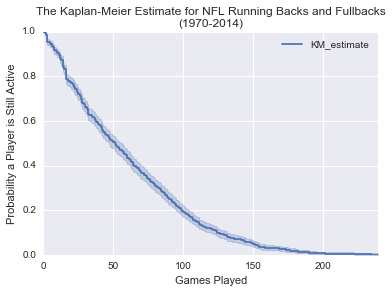

In [8]:
# plot the KM estimate
kmf.plot()
# Add title and y-axis label
plt.title("The Kaplan-Meier Estimate for NFL Running Backs and Fullbacks\n(1970-2014)")
plt.xlabel("Games Played")
plt.ylabel("Probability a Player is Still Active")

plt.show()

The median career length of NFL RB's who played from 1978-2015 is: 53.0 games.
The median career length of NFL RB's who played from 1970-1977 is: 39.0 games.


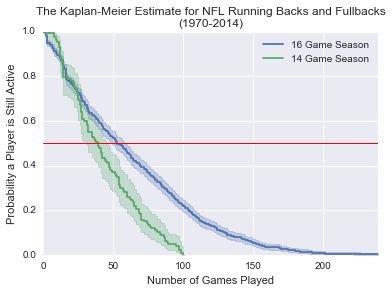

In [10]:
kmf=KaplanMeierFitter()

T = rushdfGamesSort.tot_games
C = rushdfGamesSort.retire_released

ax = plt.subplot(111)

data16 = (rushdfGamesSort["Season_len"] == 16)
kmf.fit(T[data16], event_observed=C[data16], label="16 Game Season")
print("The median career length of NFL RB's who played from 1978-2015 is:",kmf.median_, "games.")
kmf.plot(ax=ax)
kmf.fit(T[~data16], event_observed=C[~data16], label="14 Game Season")
print("The median career length of NFL RB's who played from 1970-1977 is:",kmf.median_, "games.")
kmf.plot(ax=ax)
plt.axhline(y=0.50, linewidth = 1, color = 'r')
plt.ylim(0,1);

plt.title("The Kaplan-Meier Estimate for NFL Running Backs and Fullbacks\n(1970-2014)")
plt.xlabel("Number of Games Played")
plt.ylabel("Probability a Player is Still Active")

The median career length of NFL RB's who start at age 21 is: 104.0 games.
The median career length of NFL RB's who start at age 22 is: 72.0 games.
The median career lengths of NFL RB's who start at age 23 is: 58.0 games.
The median career lengths of NFL RB's who start at age 24 is: 42.0 games.
The median career lengths of NFL RB's who start at an age greater than 24 is: 28.0 games.


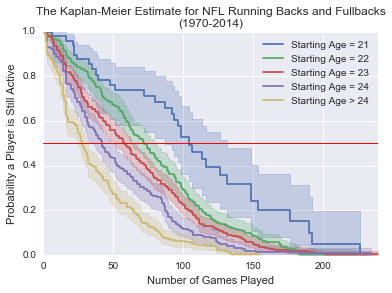

In [11]:
kmf=KaplanMeierFitter()

T = rushdfGamesSort.tot_games
C = rushdfGamesSort.retire_released

ax = plt.subplot(111)

data21 = (rushdfGamesSort["start_age"] == 21)
data22 = (rushdfGamesSort["start_age"] == 22)
data23 = (rushdfGamesSort["start_age"] == 23)
data24 = (rushdfGamesSort["start_age"] == 24)
data24plus = (rushdfGamesSort["start_age"] > 24)

kmf.fit(T[data21], event_observed=C[data21], label="Starting Age = 21")
kmf.plot(ax=ax)
print("The median career length of NFL RB's who start at age 21 is:",kmf.median_, "games.")
kmf.fit(T[data22], event_observed=C[data22], label="Starting Age = 22")
kmf.plot(ax=ax)
print("The median career length of NFL RB's who start at age 22 is:",kmf.median_,"games." )
kmf.fit(T[data23], event_observed=C[data23], label="Starting Age = 23")
kmf.plot(ax=ax)
print("The median career lengths of NFL RB's who start at age 23 is:",kmf.median_, "games.")
kmf.fit(T[data24], event_observed=C[data24], label="Starting Age = 24")
kmf.plot(ax=ax)
print("The median career lengths of NFL RB's who start at age 24 is:",kmf.median_, "games.")
kmf.fit(T[data24plus], event_observed=C[data24plus], label="Starting Age > 24")
kmf.plot(ax=ax)
print("The median career lengths of NFL RB's who start at an age greater than 24 is:",kmf.median_, "games.")
plt.axhline(y=0.50, linewidth = 1, color = 'r')
plt.ylim(0,1);

plt.title("The Kaplan-Meier Estimate for NFL Running Backs and Fullbacks\n(1970-2014)")
plt.xlabel("Number of Games Played")
plt.ylabel("Probability a Player is Still Active")

In [20]:
kmf=KaplanMeierFitter()
kmf.fit(durations=rushdfGamesSort.seasons,event_observed=rushdfGamesSort.retire_released)

<lifelines.KaplanMeierFitter: fitted with 1227 observations, 119 censored>

The median career length of NFL RB's is: 4.0 seasons.


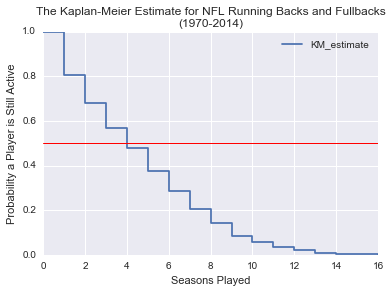

In [22]:
# plot the KM estimate
kmf.plot(ci_show = False)
plt.axhline(y=0.50, linewidth = 1, color = 'r')
print("The median career length of NFL RB's is:",kmf.median_, "seasons.")
# Add title and y-axis label
plt.title("The Kaplan-Meier Estimate for NFL Running Backs and Fullbacks\n(1970-2014)")
plt.xlabel("Seasons Played")
plt.ylabel("Probability a Player is Still Active")

plt.show()

The median career length of NFL RB's who played from 1978-2014 is: 4.0 seasons.
The median career length of NFL RB's who who played from 1970-1977 is: 3.0 seasons.


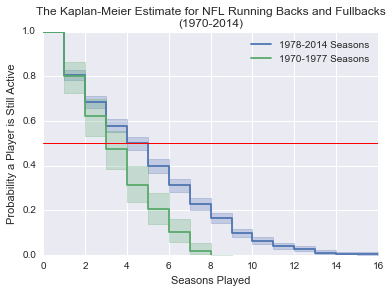

In [15]:
kmf=KaplanMeierFitter()

T = rushdfGamesSort.seasons
C = rushdfGamesSort.retire_released

ax = plt.subplot(111)

data16 = (rushdfGamesSort["Season_len"] == 16)
kmf.fit(T[data16], event_observed=C[data16], label="1978-2014 Seasons")
kmf.plot(ax=ax)
print("The median career length of NFL RB's who played from 1978-2014 is:",kmf.median_, "seasons.")
kmf.fit(T[~data16], event_observed=C[~data16], label="1970-1977 Seasons")
kmf.plot(ax=ax)
print("The median career length of NFL RB's who who played from 1970-1977 is:",kmf.median_, "seasons.")
plt.axhline(y=0.50, linewidth = 1, color = 'r')
plt.ylim(0,1);

plt.title("The Kaplan-Meier Estimate for NFL Running Backs and Fullbacks\n(1970-2014)")
plt.xlabel("Seasons Played")
plt.ylabel("Probability a Player is Still Active")


The median career length of NFL RB's who start at age 21 is: 8.0 seasons.
The median career length of NFL RB's who start at age 22 is: 6.0 seasons.
The median career length of NFL RB's who start at age 23 is: 5.0 seasons.
The median career length of NFL RB's who start at age 24 is: 3.0 seasons.
The median career length of NFL RB's who start at an age greater than 24 is: 2.0 seasons.


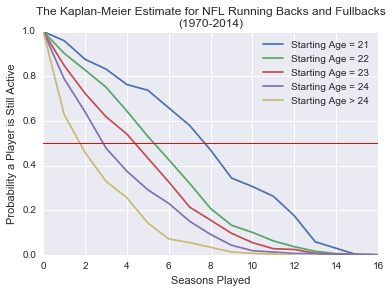

In [24]:
kmf=KaplanMeierFitter()

T = rushdfGamesSort.seasons
C = rushdfGamesSort.retire_released

ax = plt.subplot(111)

data21 = (rushdfGamesSort["start_age"] == 21)
data22 = (rushdfGamesSort["start_age"] == 22)
data23 = (rushdfGamesSort["start_age"] == 23)
data24 = (rushdfGamesSort["start_age"] == 24)
data24plus = (rushdfGamesSort["start_age"] > 24)

kmf.fit(T[data21], event_observed=C[data21], label="Starting Age = 21")
kmf.survival_function_.plot(ax=ax)
print("The median career length of NFL RB's who start at age 21 is:",kmf.median_, "seasons.")
kmf.fit(T[data22], event_observed=C[data22], label="Starting Age = 22")
kmf.survival_function_.plot(ax=ax)
print("The median career length of NFL RB's who start at age 22 is:",kmf.median_, "seasons.")
kmf.fit(T[data23], event_observed=C[data23], label="Starting Age = 23")
kmf.survival_function_.plot(ax=ax)
print("The median career length of NFL RB's who start at age 23 is:",kmf.median_, "seasons.")
kmf.fit(T[data24], event_observed=C[data24], label="Starting Age = 24")
kmf.survival_function_.plot(ax=ax)
print("The median career length of NFL RB's who start at age 24 is:",kmf.median_, "seasons.")
kmf.fit(T[data24plus], event_observed=C[data24plus], label="Starting Age > 24")
kmf.survival_function_.plot(ax=ax)
print("The median career length of NFL RB's who start at an age greater than 24 is:",kmf.median_, "seasons.")
plt.axhline(y=0.50, linewidth = 1, color = 'r')
plt.ylim(0,1);

plt.title("The Kaplan-Meier Estimate for NFL Running Backs and Fullbacks\n(1970-2014)")
plt.xlabel("Seasons Played")
plt.ylabel("Probability a Player is Still Active")